# Descrizione
Plotto le attivazioni dei dipoli su corteccia. <br>

Faccio questi grafici qui:

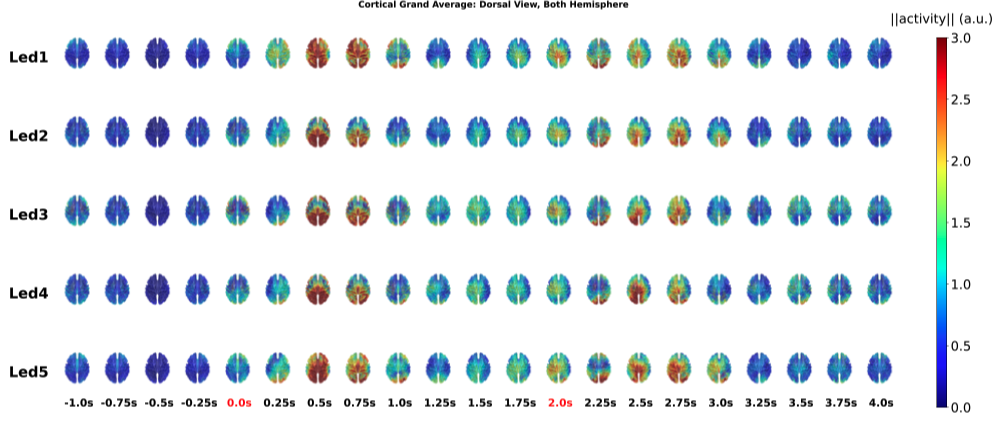

# Preparazione

**Imports**

In [ ]:
import os
import numpy as np
import mne
import pickle
import glob
import matplotlib.pyplot as plt
from mne.minimum_norm import make_inverse_operator, apply_inverse_raw
import time

**Carico il grand average che ho salvato**

In [ ]:
# Load Grand Average
load_path = '/Users/federico/University/Magistrale/00.TESI/data_original/common_data'
with open(os.path.join(load_path, 'grand_average_v1.pkl'), 'rb') as f:
    m_dict = pickle.load(f)
grand_average = m_dict['grand_average']
info = m_dict['info']

**Carico il forward model**

In [ ]:
# Load forward model
load_path = os.path.join('/Users/federico/University/Magistrale/00.TESI/data_original/experiment0/common_data/'
                         'forward_model/biosemi', 'experiment0-fwd.fif')
fwd = mne.read_forward_solution(load_path)

**Definisco il percorso di salvataggio delle immagini**

In [ ]:
# Images save_path
save_path = '/Users/federico/University/Magistrale/00.TESI/data_original/THESIS_IMAGES/cortex/voxel_v250'
if not os.path.exists(save_path):
    os.makedirs(save_path)

**Parametri e creazione inverse model**

In [ ]:
# Inverse operator parameters
loose = 1
fixed = False

# Apply inverse epochs operator parameters
method = 'eLORETA'
snr = 3.
lambda2 = 1. / snr ** 2
pick_ori = 'vector'
srate = 512

# noise_cov = mne.read_cov(cov_path)
noise_cov = mne.make_ad_hoc_cov(info, std=1)

# Make inverse operator
inverse_operator = make_inverse_operator(info=info,
                                         forward=fwd,
                                         noise_cov=noise_cov,
                                         loose=loose,
                                         fixed=fixed,
                                         verbose=False)

**Parametri temporali, labels**

In [ ]:
samples = np.linspace(0, 2560, 21).astype(int)
samples[1:] = samples[1:] - 1
tcs = dict()
src = inverse_operator['src']
subjects_dir = mne.datasets.sample.data_path() / 'subjects'
labels = mne.read_labels_from_annot(subject='fsaverage', parc='aparc')
labels = labels[:-1]

# Plotting

**Parametri vista**

In [ ]:
# View Param
hemi = 'both'
views = 'dorsal'
window = 0.25

**Creo le immagini singole e le salvo in save_path**

In [ ]:
for c, ga in enumerate(grand_average):
    ga_raw = mne.io.RawArray(ga, info)
    ga_raw = ga_raw.copy().set_eeg_reference(projection=True)
    ga_raw.apply_proj()
    t = time.time()
    stc = apply_inverse_raw(raw=ga_raw,
                            inverse_operator=inverse_operator,
                            lambda2=lambda2,
                            method=method,
                            pick_ori=pick_ori,
                            verbose=False)
    elapsed = time.time() - t
    print(f'Elapsed time = {elapsed} seconds')

    samples = np.linspace(0, stc.data.shape[2], 21).astype(int)
    samples[1:] = samples[1:] - 1
    clim = dict(kind='value', lims=[0, 1.5e-12, 3e-12])
    tcs['led'+str(c+1)] = stc.extract_label_time_course(labels, src, mode='mean')

    for ss, sample in enumerate(samples):
        if sample == samples[0]:
            pre = 0
            post = int(srate * window)
        elif sample == samples[-1]:
            pre = int(srate * window)
            post = 0
        else:
            pre = int(srate * 0.5 * window)
            post = pre
        tmp_data = np.mean(stc.data[:, :, sample-pre:sample+post], axis=2)
        tmp_vert = stc.vertices
        # temp_data = tmp_data.reshape((stc.data.shape[0], stc.data.shape[1], 1))
        tmp_stc = mne.VectorSourceEstimate(data=tmp_data, vertices=tmp_vert, tmin=stc.tmin, tstep=stc.tstep,
                                           subject=stc.subject)

        im = tmp_stc.plot(subject='fsaverage',
                          hemi=hemi,
                          clim=clim,
                          colormap='jet',
                          transparent=False,
                          background='white',
                          views=views,
                          time_viewer=False,
                          colorbar=False,
                          time_label=None,
                          vector_alpha=0,
                          size=200)
        if ss < 10:
            im.save_image(os.path.join(save_path, f'activation_led{c+1}_sample_00{ss}.jpg'))
        elif ss >= 10:
            im.save_image(os.path.join(save_path, f'activation_led{c+1}_sample_0{ss}.jpg'))
        im.close()


**Prendo le immagini che ho salvato sopra e le infilo in un subplot unico**

In [ ]:
# Qui carico le immagini che ho salvato per andarle a plottare unicamente in un subplot
samples = np.linspace(0, 2560, 21).astype(int)
samples[1:] = samples[1:] - 1

# Faccio in modo che le immagini abbiano una elevata risoluzione
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

# Carico tutte le immagini
images_path = glob.glob(os.path.join(save_path, 'activation*'))
images_path = sorted(images_path)

# Creo il titolo
if hemi == 'lh':
    hemi = 'left'
elif hemi == 'rh':
    hemi = 'right'
elif hemi == 'both':
    hemi = 'both'

title = f'Cortical Grand Average: {views.capitalize()} View, {hemi.capitalize()} Hemisphere'
nsample = np.shape(samples)[0]

# Inizializzo la figura
fig, axs = plt.subplots(5, nsample, figsize=(24, 11))
fig.suptitle(title, fontsize=15, fontweight='bold')

# Definisco la colorbar
colormap = plt.cm.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=colormap)
vmin = 0
vmax = 3e-12
sm.set_clim(vmin=vmin, vmax=vmax)

for img_path, ax in zip(images_path, axs.ravel()):
    print(img_path)
    im = plt.imread(img_path)
    os.remove(img_path)
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Define x_labels and y_labels
xlbl = np.arange(-1, 4.25, 0.25).tolist()
cols = ['{}s'.format(col) for col in xlbl]
rows = ['Led{}'.format(row) for row in [1, 2, 3, 4, 5]]

# Add seconds to the bottom of the figure (x_label)
for ax, col in zip(axs[-1], cols):
    if col == '0.0s' or col == '2.0s':
        ax.set_xlabel(col, fontweight='bold', fontsize=18, color='red')
        ax.xaxis.set_label_coords(0.55, -0.4)
    else:
        ax.set_xlabel(col, fontweight='bold', fontsize=18)
        ax.xaxis.set_label_coords(0.55, -0.4)

# Add LED id to left of figure (y_labels)
for ax, row in zip(axs[:, 0], rows):
    ax.set_ylabel(row, fontweight='bold', fontsize=25, rotation=0)
    ax.yaxis.set_label_coords(-0.95, 0.15)

# Adding a big colorbar to the side of the figure
cbar_ax = fig.add_axes([0.94, 0.1, 0.01, 0.8])
cb = fig.colorbar(sm, cax=cbar_ax)
cb.ax.tick_params(labelsize=22)
ticks = cb.get_ticks()
cb.ax.set_yticklabels(np.round(ticks*1e12, 1))
cb.ax.set_title('||activity|| (a.u.)', fontsize=22, y=1.03)

# Adjusting subplot distances and location inside the figure
fig.subplots_adjust(left=0.07,
                    bottom=0.1,
                    right=0.90,
                    top=0.95,
                    wspace=0.2,
                    hspace=0.01)
fig.show()
path = os.path.join(save_path, 'CORTICAL_GA-' + views + '_' + hemi + '.pdf')
fig.savefig(path)